In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
5  4.0368      52.0  4.761658   1.103627       413.0  2.139896     37.85   
6  3.6591      52.0  4.931907   0.951362      1094.0  2.128405     37.84   
7  3.1200      52.0  4.797527   1.061824      1157.0  1.788253     37.84   
8  2.0804      42.0  4.294118   1.117647      1206.0  2.026891     37.84   
9  3.6912      52.0  4.970588   0.990196      1551.0  2.172269     37.84   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  
5    -122.25   2.697  
6    -122.25   2.992  
7    -122.25   2.414  
8    -122.26   2.267  
9    -122.25   2.611

In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

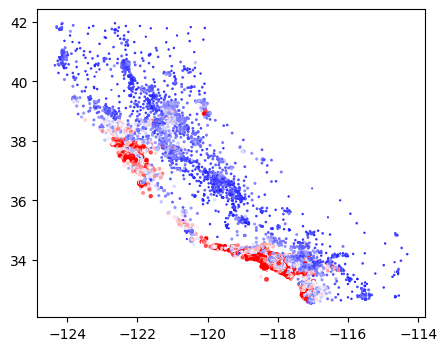

In [3]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [4]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)


Make sure to have a look at the documentation:
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [8]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


dataset = fetch_california_housing()
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

X, y = data.drop('target', axis=1), data['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


knn_preprocessor = ColumnTransformer(
    transformers=[
        ('knn_scaler', StandardScaler(), ['Longitude', 'Latitude'])
    ],
    remainder='drop'
)


rf_preprocessor = ColumnTransformer(
    transformers=[
        ('rf_scaler', StandardScaler(), list(X.columns.difference(['Longitude', 'Latitude'])))
    ],
    remainder='drop'
)


knn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_preprocessor),
    ('knn_regressor', KNeighborsRegressor(n_neighbors=5))  #n_neighbors set to 5
])


rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('rf_regressor', RandomForestRegressor(n_estimators=100))  #n_estimators set to 100
])


knn_pipeline.fit(X_train, y_train)


rf_pipeline.fit(X_train, y_train)


stacking_regressor = StackingRegressor(
    estimators=[
        ('knn', knn_pipeline),
        ('rf', rf_pipeline)
    ],
    final_estimator=LinearRegression(),
    cv=5
)


stacking_regressor.fit(X_train, y_train)

#predictions with all three models
knn_pred = knn_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)
stacking_pred = stacking_regressor.predict(X_test)


knn_mse = mean_squared_error(y_test, knn_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
stacking_mse = mean_squared_error(y_test, stacking_pred)


print(f'kNN MSE: {knn_mse}')
print(f'Random Forest MSE: {rf_mse}')
print(f'Stacking Regressor MSE: {stacking_mse}')



kNN MSE: 0.30899928113555425
Random Forest MSE: 0.43222693718985855
Stacking Regressor MSE: 0.2379808758665195



The results suggest that the Stacking Regressor is the most effective model for this particular dataset, likely due to its ability to leverage the strengths of both kNN and Random Forest models. However, the Random Forest's performance is unexpectedly lower than the other two, which could be an area for further investigation and optimization. These findings highlight the potential benefits of model ensemble techniques, like stacking, in improving prediction accuracy by combining different types of models.

##After Tuning

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


dataset = fetch_california_housing()
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


knn_preprocessor = ColumnTransformer(
    transformers=[
        ('knn_scaler', StandardScaler(), ['Longitude', 'Latitude'])
    ],
    remainder='drop'
)


rf_preprocessor = ColumnTransformer(
    transformers=[
        ('rf_scaler', StandardScaler(), list(X.columns.difference(['Longitude', 'Latitude'])))
    ],
    remainder='drop'
)

knn_pipeline = Pipeline([
    ('preprocessor', knn_preprocessor),
    ('knn_regressor', KNeighborsRegressor())
])

knn_param_grid = {
    'knn_regressor__n_neighbors': [3, 5, 7, 10]
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)


rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('rf_regressor', RandomForestRegressor())
])

rf_param_grid = {
    'rf_regressor__n_estimators': [50, 100, 150],
    'rf_regressor__max_depth': [10, 20, None]
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

stacking_regressor = StackingRegressor(
    estimators=[
        ('knn', knn_grid_search.best_estimator_),
        ('rf', rf_grid_search.best_estimator_)
    ],
    final_estimator=LinearRegression(),
    cv=5
)
stacking_regressor.fit(X_train, y_train)


knn_pred = knn_grid_search.predict(X_test)
rf_pred = rf_grid_search.predict(X_test)
stacking_pred = stacking_regressor.predict(X_test)


knn_mse = mean_squared_error(y_test, knn_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
stacking_mse = mean_squared_error(y_test, stacking_pred)


print(f'kNN GridSearchCV MSE: {knn_mse}')
print(f'Random Forest GridSearchCV MSE: {rf_mse}')
print(f'Stacking Regressor MSE: {stacking_mse}')


kNN GridSearchCV MSE: 0.3058998260349173
Random Forest GridSearchCV MSE: 0.4257914365065261
Stacking Regressor MSE: 0.2336486116294619


The Stacking Regressor's superior performance underscores the power of ensemble methods in machine learning, particularly in situations where single models might not capture the complete patterns in the data.
The improvements in MSE for both the kNN and Random Forest models after hyperparameter tuning highlight the importance of this step.
Also there is the relatively higher MSE for the Random Forest model.
Finally, these results demonstrate how different models can be effectively combined to enhance the predictive capabilities in a regression task, leveraging the unique strengths of each model.